In [1]:
import numpy as np
import json
import csv
import re
import glob
from matplotlib import pyplot as plt
from PIL import Image
from skimage import color
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score

from subprocess import check_output
#print(check_output(["ls", "./all/train/images"]).decode("utf8"))
totalImagesToUse = 5 #How many images should be displayed below.

In [2]:
labels = []
with open(r'./all/train.csv', newline='') as csvfile:
    saltReader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    iter = 0
    p = re.compile(r'.*,')
    currentRowIndex = 0
    for row in saltReader:
        #now we need to break up each row by one comma and then spaces.
        rowSum = 0
        if(currentRowIndex > 0):
            name = p.match("".join(row[0])).group(0)
            #print(name)
            for entry in row:
                value = p.sub('', "".join(entry))
                if(value.isdigit()):
                    rowSum += int(value)
            if(rowSum > 0):
                labels.append(1)
            else:
                labels.append(0)
        currentRowIndex += 1
        
        #Need to categorize each image as containing or not containing.


In [3]:
#Lets go through the images in the dataset and create an array of them.
img_length = 101
rawImages = []
count = 0
for filename in glob.glob('./all/train/images/*.png'): 
    im=Image.open(filename)
    rawImages.append(im)
    count += 1
    #if(count == totalImagesToUse):
        #break

In [4]:
maskImages = []
count = 0
for filename in glob.glob('./all/train/masks/*.png'):
    im=Image.open(filename)
    maskImages.append(im.copy())
    im.close()
    count += 1

In [5]:
#ok, so above takes all the files from our folder and puts them in an array
# Now we need to go through each file and calculate the HOG on each. We didn't necessarilly convert them to gray scale but they are.
ppc = 16
hogImages = []
hog_features = []
count = 1
for image in rawImages:
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2',visualize=True)
    hogImages.append(hog_image)
    hog_features.append(fd)
    count += 1

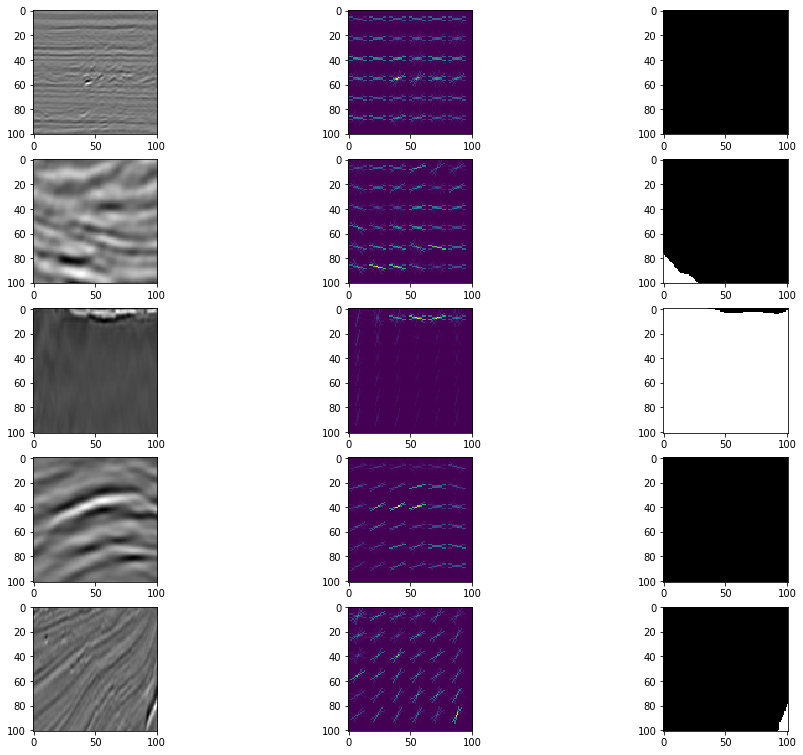

In [6]:
#What we want to see is the image, the HOG, and then the rle mask
col = 3
row = totalImagesToUse + 1
count = 1
sideBySideFigure = plt.figure(figsize=(16,16))
for i in range(0, totalImagesToUse):
    sideBySideFigure.add_subplot(row,col,count)
    plt.imshow(rawImages[i])
    count += 1
    sideBySideFigure.add_subplot(row,col,count)
    plt.imshow(hogImages[i])
    count += 1
    sideBySideFigure.add_subplot(row,col,count)
    plt.imshow(maskImages[i])
    count += 1
    


In [7]:
#Now that I have an idea of the hogs, we need to attach the labels to each hog.
labels = np.array(labels).reshape(len(labels),1)
print(labels.shape)

(4000, 1)


In [8]:
#Using the HOG+Label array, create an SVM
clf = svm.SVC()
hog_features = np.array(hog_features)
data = np.concatenate((hog_features,labels), axis=1)
np.random.shuffle(data)

In [9]:
#What percentage of data you want to keep for training
percentage = 80
split = int(len(hog_features)*percentage/100) #where we split in our hog_features array.

x_train, x_test = data[:split,:-1],  data[split:,:-1]
y_train, y_test = data[:split,-1:].ravel() , data[split:,-1:].ravel()

clf.fit(x_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [10]:
y_pred = clf.predict(x_test)
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.6125


             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00       310
        1.0       0.61      1.00      0.76       490

avg / total       0.38      0.61      0.47       800



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
